# Regriding

In [34]:
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import warnings
warnings.filterwarnings('ignore')

## Load target and training grids

In [35]:
# Target
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
target = cat['gmet_v2'].to_dask()
tgt_lat = target['lat']
tgt_lon = target['lon']
tgt_grid = xr.Dataset({'lat': (['lat'], tgt_lat),
                     'lon': (['lon'], tgt_lon),
                    }
                   )

# Training
cat = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r2i1p1f1'])
train = cat.to_dataset_dict()
train_lat = train['CMIP.NCAR.CESM2.historical.day.gn']['lat']
train_lon = train['CMIP.NCAR.CESM2.historical.day.gn']['lon']
train_grid = xr.Dataset({'lat': (['lat'], train_lat),
                     'lon': (['lon'], train_lon),
                    }
                   )


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


## Regrid training to target

In [36]:
data = train['CMIP.NCAR.CESM2.historical.day.gn']['pr']
regridder = xe.Regridder(data, tgt_grid, 'bilinear')
regridded_data = regridder(data)

Overwrite existing file: bilinear_192x288_224x464.nc 
 You can set reuse_weights=True to save computing time.


<xarray.DataArray 'pr' (member_id: 1, time: 60226, lat: 224, lon: 464)>
dask.array<regrid_numpy, shape=(1, 60226, 224, 464), dtype=float64, chunksize=(1, 3650, 224, 464), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) <U8 'r2i1p1f1'
  * lon        (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0
  * lat        (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
Attributes:
    regrid_method:  bilinear

## Plot Regrided Data

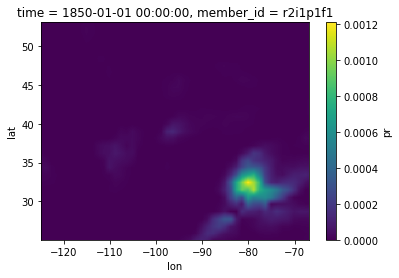

In [38]:
regridded_data[0,0,:,:].plot()